In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

np.set_printoptions(suppress=True, precision=3)

sns.set(style='ticks', palette='Set2')
sns.despine()

In [2]:
import utils as U
import opt_runs as OR
import opt_model as OM
import decorated_options as Deco

/Users/musically_ut/prog/work/LVIV-2018/redqueen/opt_runs.py:19: UserWarning: broadcast.opt.optimizer was NOT imported. Comparison against method of Karimi et. al. method will not be possible.
  warnings.warn('broadcast.opt.optimizer was NOT imported. '


# Step 1: Create a SimOpts which will generate raw data

In [3]:
sim_opts_1_follower = OM.SimOpts(
    src_id=0,
    end_time=100,
    s=np.array([1]),
    q=1.0,
    other_sources=[('Hawkes', {'src_id': 1, 'seed': 1, 'l_0': 1.0, 'alpha': 1.0, 'beta': 5.0})],
    sink_ids=[1000],
    edge_list=[(0, 1000), (1, 1000)]
)
src_id = sim_opts_1_follower.src_id

# Step 2: Simulate the walls along with different strategies for our broadcaster

### RedQueen

In [96]:
%%time
seed = 1
opt_mgr = sim_opts_1_follower.create_manager_with_opt(seed)
opt_mgr.run_dynamic()
opt_df = opt_mgr.state.get_dataframe()
num_opt_tweets = U.num_tweets_of(opt_df, broadcaster_id=src_id)
perf_opt = {
    'type': 'Opt',
    'seed': seed,
    'capacity': num_opt_tweets,
    'q': sim_opts_1_follower.q,
}
OR.add_perf(perf_opt, opt_df, sim_opts_1_follower)

CPU times: user 80.3 ms, sys: 3.37 ms, total: 83.7 ms
Wall time: 82.1 ms


In [97]:
perf_opt

{'avg_rank': 66.8116376874034,
 'capacity': 78.0,
 'num_events': 78,
 'q': 1.0,
 'r_2': 138.15727122691501,
 'seed': 1,
 'top_1': 56.517519051405124,
 'type': 'Opt',
 'world_events': 154}

### Poisson

In [98]:
%%time
seed = 9
poisson_mgr = sim_opts_1_follower.create_manager_with_poisson(seed, capacity=num_opt_tweets)
poisson_mgr.run_dynamic()
poisson_df = poisson_mgr.state.get_dataframe()
num_poisson_tweets = U.num_tweets_of(poisson_df, broadcaster_id=src_id)
perf_poisson = {
    'type': 'Poisson',
    'seed': seed,
    'capacity': num_poisson_tweets,
    'q': sim_opts_1_follower.q
}
OR.add_perf(perf_poisson, poisson_df, sim_opts_1_follower)

CPU times: user 95.5 ms, sys: 4.15 ms, total: 99.6 ms
Wall time: 101 ms


In [99]:
perf_poisson

{'avg_rank': 201.3461740580856,
 'capacity': 78.0,
 'num_events': 78,
 'q': 1.0,
 'r_2': 1341.2792390212567,
 'seed': 9,
 'top_1': 39.68728199394901,
 'type': 'Poisson',
 'world_events': 154}

### Smart Poisson

In [102]:
%%time
seed = 24

T = sim_opts_1_follower.end_time

rate = num_opt_tweets / T * 4
sp_mgr = sim_opts_1_follower.create_manager_with_smart_poisson(
    seed,
    rate=rate
)

sp_mgr.run_dynamic()
sp_df = sp_mgr.state.get_dataframe()
num_sp_tweets = U.num_tweets_of(sp_df, broadcaster_id=src_id)
perf_sp = {
    'type': 'Smart Poisson',
    'seed': seed,
}
OR.add_perf(perf_sp, sp_df, sim_opts_1_follower)

CPU times: user 81.9 ms, sys: 4.64 ms, total: 86.5 ms
Wall time: 84 ms


In [103]:
perf_sp

{'avg_rank': 77.16101427531228,
 'num_events': 80,
 'r_2': 403.80126498258875,
 'seed': 24,
 'top_1': 63.975107578107554,
 'type': 'Smart Poisson',
 'world_events': 154}

### Piecewise constant

In [100]:
%%time
seed = 24

T = sim_opts_1_follower.end_time

# Keep the rate such that the number of events is roughtly the same as the number of posts
# made by RedQueen, but such that intensity of posting increases with time.
segments = 10
change_times = np.arange(0, segments) * T / segments
rates = np.arange(0, segments) * (2 * num_opt_tweets / T) / (segments - 1)

pwc_mgr = sim_opts_1_follower.create_manager_with_piecewise_const(
    seed, 
    change_times=change_times,
    rates=rates
)

pwc_mgr.run_dynamic()
pwc_df = pwc_mgr.state.get_dataframe()
num_pwc_tweets = U.num_tweets_of(pwc_df, broadcaster_id=src_id)
perf_pwc = {
    'type': 'PWC',
    'seed': seed,
    'capacity': num_pwc_tweets,
}
OR.add_perf(perf_pwc, pwc_df, sim_opts_1_follower)

CPU times: user 84.3 ms, sys: 2.82 ms, total: 87.1 ms
Wall time: 86.1 ms


In [101]:
perf_pwc

{'avg_rank': 792.0379281739264,
 'capacity': 78.0,
 'num_events': 78,
 'r_2': 22260.201256104978,
 'seed': 24,
 'top_1': 31.66329884023582,
 'type': 'PWC',
 'world_events': 154}

### Hawkes

In [106]:
%%time
seed = 489

T = sim_opts_1_follower.end_time
l_0, alpha, beta = 0.5, 0.5, 1.0
hawkes_broadcaster = OM.Hawkes(src_id=src_id, l_0=l_0, alpha=alpha, beta=beta, seed=seed)

hawkes_mgr = sim_opts_1_follower.create_manager_with_broadcaster(hawkes_broadcaster)

hawkes_mgr.run_dynamic()
hawkes_df = hawkes_mgr.state.get_dataframe()
num_hawkes_tweets = U.num_tweets_of(hawkes_df, broadcaster_id=src_id)
perf_hawkes = {
    'type': 'Hawkes',
    'seed': seed,
    'alpha': alpha,
    'beta': beta,
    'l_0': l_0,
}
OR.add_perf(perf_hawkes, hawkes_df, sim_opts_1_follower)

CPU times: user 90 ms, sys: 2.93 ms, total: 92.9 ms
Wall time: 95.8 ms


In [107]:
perf_hawkes

{'alpha': 0.5,
 'avg_rank': 272.3440076606438,
 'beta': 1.0,
 'l_0': 0.5,
 'num_events': 78,
 'r_2': 3744.460460961055,
 'seed': 489,
 'top_1': 41.09226240618488,
 'type': 'Hawkes',
 'world_events': 154}

# Step 3: Study the performance

In [114]:
experiments = {
    'Poisson': poisson_df,
    'Hawkes': hawkes_df,
    'Smart': sp_df,
    'PWC': pwc_df,
    'RedQueen': opt_df,
}

In [115]:
for kind, df in experiments.items():
    print('kind = {}\t\t num_tweets = {}'.format(kind, U.num_tweets_of(opt_df, src_id)))

kind = Poisson		 num_tweets = 78.0
kind = Hawkes		 num_tweets = 78.0
kind = Smart		 num_tweets = 78.0
kind = PWC		 num_tweets = 78.0
kind = RedQueen		 num_tweets = 78.0


In [116]:
for kind, df in experiments.items():
    print('kind = {}\t\t avg_rank = {}'
          .format(kind, U.average_rank(df, sim_opts=sim_opts_1_follower)))

kind = Poisson		 avg_rank = 201.3461740580856
kind = Hawkes		 avg_rank = 272.3440076606438
kind = Smart		 avg_rank = 77.16101427531228
kind = PWC		 avg_rank = 792.0379281739264
kind = RedQueen		 avg_rank = 66.8116376874034


In [117]:
K = 1
for kind, df in experiments.items():
    print('kind = {}\t\t top-{} = {}'
          .format(kind, K, U.time_in_top_k(df, K=K, sim_opts=sim_opts_1_follower)))

kind = Poisson		 top-1 = 39.68728199394901
kind = Hawkes		 top-1 = 41.09226240618488
kind = Smart		 top-1 = 63.975107578107554
kind = PWC		 top-1 = 31.66329884023582
kind = RedQueen		 top-1 = 56.517519051405124


### Rank

In [123]:
def plot_rank_evolution(df, src_id, title=None):
    # plt.figure(figsize=(8,6))
    
    c1, c2 = sns.color_palette(n_colors=2)

    ranks = U.rank_of_src_in_df(df, src_id).mean(axis=1)
    
    fig, ax1 = plt.subplots()
    
    ax1.fill_between(ranks.index, ranks.values, step='post',
                     color=c1, label=r'$\bar{r}(t)$', alpha=0.5)
    
    ax1.set_ylabel('Rank')
    ax1.set_xlabel('Time')
    ax1.tick_params('y', colors=c1)
    ax1.set_ylim(0)
    
    tweet_times = df[(df.src_id == src_id)].t.unique()
    num_tweets = tweet_times.shape[0]
    
    ax2 = ax1.twinx()
    ax2.step(tweet_times, np.arange(num_tweets),
             label='$N(t)$', color=c2, linewidth=1.0)
    
    ax2.set_ylabel('Tweets')
    ax2.tick_params('y', colors=c2)
    ax2.set_ylim(0)
    
    if title is not None:
        plt.title(title)
    
    plt.tight_layout()

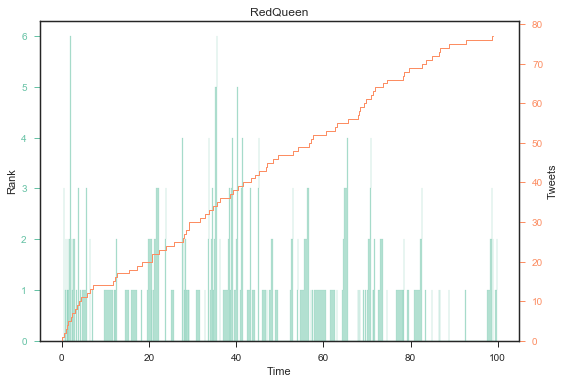

In [124]:
plot_rank_evolution(opt_df, src_id, title='RedQueen')

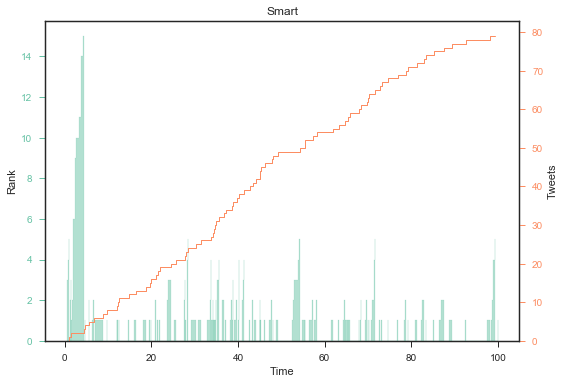

In [125]:
plot_rank_evolution(sp_df, src_id, title='Smart')

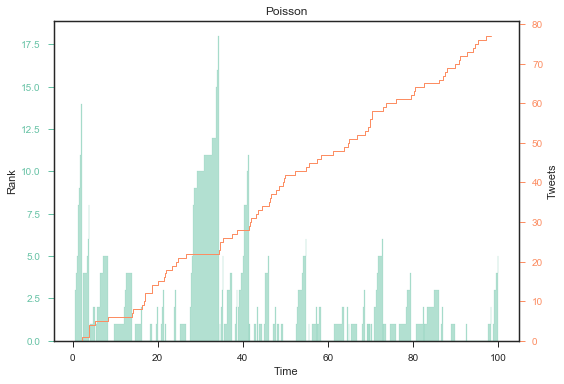

In [126]:
plot_rank_evolution(poisson_df, src_id, title='Poisson')

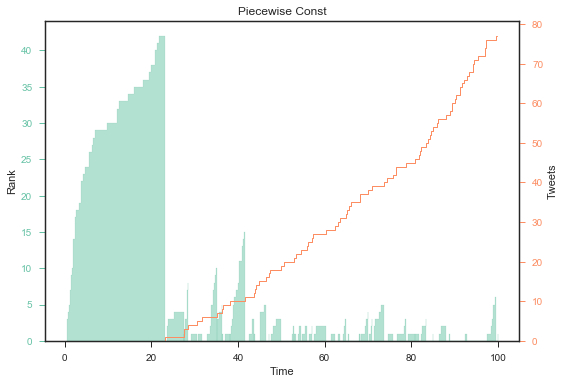

In [135]:
plot_rank_evolution(pwc_df, src_id, title='Piecewise Const')

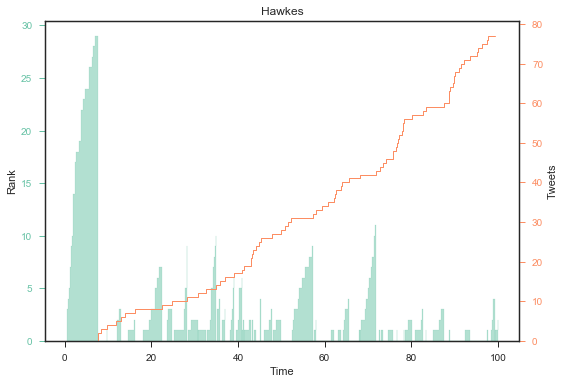

In [128]:
plot_rank_evolution(hawkes_df, src_id, title='Hawkes')

### Top-k

In [129]:
def plot_top_k_evolution(df, src_id, K=1, T=100, ymax=None, title=None):
    # plt.figure(figsize=(8,6))    
    c1, c2 = sns.color_palette(n_colors=2)

    top_k = (U.rank_of_src_in_df(df, src_id) < K).mean(axis=1)
    
    times = np.asarray([0] + top_k.index.values.tolist() + [T])
    t_diff = np.diff(times)
    top_k_indicator = np.array([0] + top_k.values.tolist())

    fig, ax1 = plt.subplots()    

    ax1.fill_between(times[:-1], np.cumsum(top_k_indicator * t_diff), step='post',
                     color=c1, label=r'$1_{[r(t) <= %d]}$' % K,
                     alpha=0.5)
    
    ax1.set_ylabel('Time in Top-{}'.format(K))
    ax1.set_xlabel('Time')
    ax1.tick_params('y', colors=c1)
    
    if ymax is None:
        ax1.set_ylim(0)
    else:
        ax1.set_ylim(0, ymax)
    
    tweet_times = df[(df.src_id == src_id)].t.unique()
    num_tweets = tweet_times.shape[0]
    
    ax2 = ax1.twinx()
    # plt.vlines(tweet_times[one_month_df] * 60 / 10000, ymin=0, ymax=1200, color=c2, linewidth=0.5)
    ax2.step(tweet_times, np.arange(num_tweets),
             label='$N(t)$', color=c2, linewidth=1.0)
    
    ax2.set_ylabel('Tweets')
    ax2.tick_params('y', colors=c2)
    ax2.set_ylim(0)
    
    if title is not None:
        plt.title(title)
        
    plt.tight_layout()

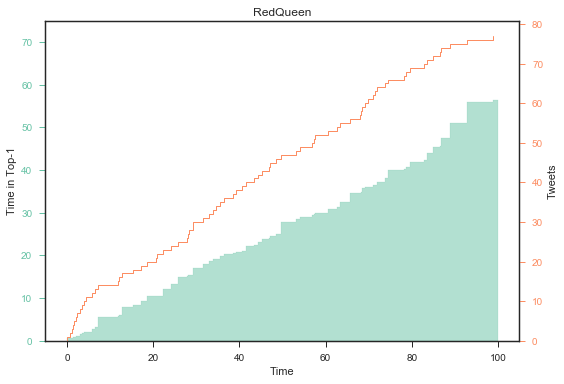

In [131]:
plot_top_k_evolution(opt_df, src_id, ymax=75, title='RedQueen')

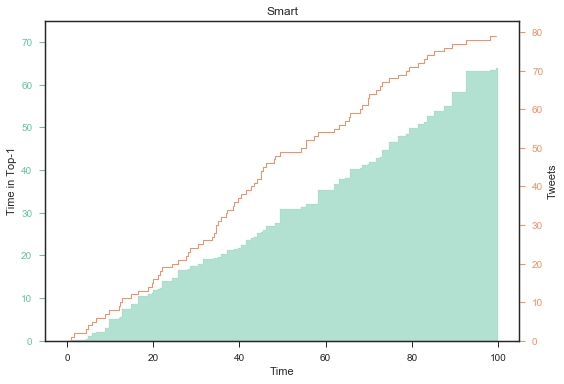

In [132]:
plot_top_k_evolution(sp_df, src_id, ymax=75, title='Smart')

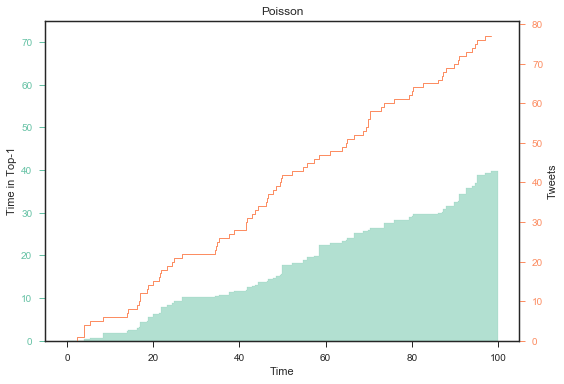

In [133]:
plot_top_k_evolution(poisson_df, src_id, ymax=75, title='Poisson')

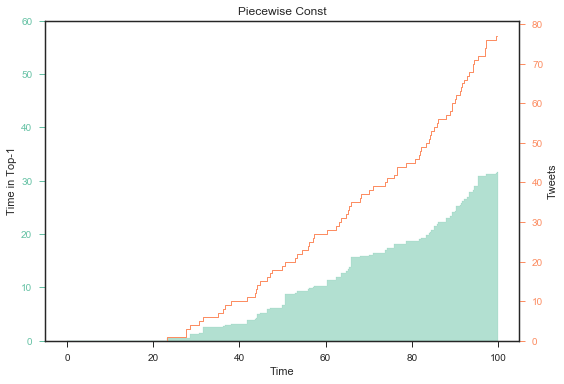

In [134]:
plot_top_k_evolution(pwc_df, src_id, ymax=60, title='Piecewise Const')

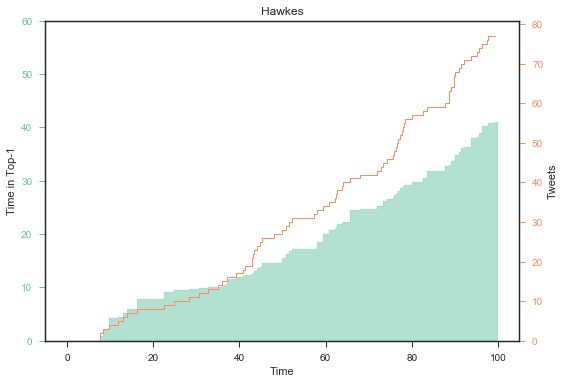

In [136]:
plot_top_k_evolution(hawkes_df, src_id, ymax=60, title='Hawkes')